The program runs with the data file being in the same directory as the notebook.
Running with GPU is recommended.
Since the training process is slow, the trained model is provided. Put the trained model in the same directory and the testing part can generate its performance.

A version for Google colab is also provided. For the colab notebook, uploading the data and creating a folder for model checkpoints are needed, and the corresponding directories need to be added in the config part.

In [1]:
# necessary packages
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple

In [2]:
# general settings of the algorithm
config = {
    "datafile_name": "SPX.GIf.csv",
    "train_start_date": "1996-01-01",
    "train_end_date": "2004-01-01",
    "test_start_date": "2004-01-01", 
    "test_end_date": "2004-08-31",
    "history_length": 60,  # length of price (close) and volume history in each state
    "tech_idx_length": 20,  # length of technical index history in each state
    "memory_size": 400,  # size of the replay memory buffer
    "batch_size": 100,
    "learning_rate": 1e-4, 
    "weight_decay": 0.0005,  # parameters for Adam optimizer
    "discount_rate": 0.98,  # discount rate in RL
    "epsilon_start": 1, 
    "epsilon_reduce_portion": 0.7, 
    "epsilon_reduce_freq": 10,  # parameters for epsilon decay
    "train_freq": 30,  # for every train_freq steps, train the model
    "save_freq": 5,  # for every save_freq epochs, save the model to the checkpoint
    "update_model_target_freq": 10,  # update policy model to target model every 10 epochs
    "num_epoch": 100, 
    "device": torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    "use_checkpoint": False  # set this to True to load checkpoint model instead of training from scratch
}

In [3]:
# random seed used to reproduce the same result
np.random.seed(3)
random.seed(3)
torch.manual_seed(3)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(4)
torch.backends.cudnn.deterministic = True

In [4]:
# Environment

class Environment:
    '''
    This class is the environment we have for the model, which includes a state space, an action space,
    and a reward function.
    Every time we make an action, a state consisting of price, volume, rsi, boll, macd, will, will be returned,
    and the corresponding reward of that action will also be returned.
    '''

    def __init__(self, data, history_length, tech_idx_length):
        self.data = data
        self.history_length = history_length # consider historical price and volumn data
        self.tech_idx_length = tech_idx_length # consider historical technical index data
        self.t = 0 # time step
        self.history = [0] * self.history_length
        self.vol_history = [0] * self.history_length
        self.rsi = [0] * self.tech_idx_length
        self.boll = [0] * self.tech_idx_length
        self.macd = [0] * self.tech_idx_length
        self.will = [0] * self.tech_idx_length
    
    # reset the state at the beginning of each epoch
    def reset(self):
        self.t = 0
        self.history = [0] * self.history_length
        self.vol_history = [0] * self.history_length
        self.rsi = [0] * self.tech_idx_length
        self.boll = [0] * self.tech_idx_length
        self.macd = [0] * self.tech_idx_length
        self.will = [0] * self.tech_idx_length
        return self.history + self.vol_history + self.rsi + self.boll + self.macd + self.will
    
    # call actions
    def __call__(self, action):

        reward = 0
        price = self.data.iloc[self.t, :]['Close']

        if action == 1:  # Follow trend
            reward = self.data.iloc[self.t + 1, :]['Close'] - price
        elif action == 2:  # Against trend
            reward = price - self.data.iloc[self.t + 1, :]['Close']
        # otherwise action is 0, which means neutral and zero-reward
        
        # oldest data out, latest data in 
        self.history.pop(0)
        self.history.append(price)
        self.vol_history.pop(0)
        self.vol_history.append(self.data.iloc[self.t, :]['Volume'])
        self.rsi.pop(0)
        self.rsi.append(self.data.iloc[self.t, :]['rsi'])
        self.boll.pop(0)
        self.boll.append(self.data.iloc[self.t, :]['bollinger'])
        self.macd.pop(0)
        self.macd.append(self.data.iloc[self.t, :]['DEA'])
        self.will.pop(0)
        self.will.append(self.data.iloc[self.t, :]['william'])
        self.t += 1

        return self.history + self.vol_history + self.rsi + self.boll + self.macd + self.will, reward


In [5]:
# Network

class QNetwork(torch.nn.Module):
    '''
    This is the neural network model we have. We use pytorch to help us with backpropagation and update losses.
    For details of the structure, see the report.
    '''
    
    def __init__(self, input_size):
        super(QNetwork, self).__init__()
        self.input_size = input_size
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=2, bias=True), nn.BatchNorm1d(16), nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=2, bias=True), nn.ReLU(),
            nn.AvgPool1d(3),
            nn.Conv1d(32, 64, kernel_size=2, bias=True), nn.ReLU(), nn.Flatten()
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(4160, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.Sigmoid(),
            nn.Linear(256, 3)
        )

        self.init_weights()
        
    def init_weights(self):
        for module in self.conv_layers:
            if isinstance(module, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_uniform_(module.weight)
                nn.init.constant_(module.bias, 0)
        for module in self.fc_layers:
            if isinstance(module, nn.Linear):
                nn.init.kaiming_uniform_(module.weight)
                nn.init.constant_(module.bias, 0)

    def reset(self):
        self.zero_grad()

    def forward(self, x):
        x = self.conv_layers(x.view(-1, 1, self.input_size))
        x = self.fc_layers(x)
        return x


In [6]:
# Policy

def policy(model, state, device, use_epsilon=True, epsilon=0.3):
    '''
    This is the fucntion that contains the policy we use. If use_epsilon is True, we will use epsilon-greedy
    strategy. In our project, we only consider this policy, but certainly, we can turn it to False and use
    another policy.
    
    @param model: the neural network we will use;
    @param state: the state of the agent that will be fed into the model as input;
    @param device: gpu or cpu;
    @param use_epsilon: use epsilon-greedy or not, it is set to false in testing;
    @param epsilon: the initial value of epsilon
    @rvalue: return action 0, 1, 2, which has meaning defined in the environment.
    '''
    if use_epsilon:  # use epsilon greedy policy
        if np.random.rand() < epsilon:  # exploration, random policy with probability epsilon
            return np.random.choice([0, 1, 2])
        else: # exploitation
            with torch.no_grad():
                return torch.argmax(model(torch.Tensor(state).view(1, -1).to(device)))
    else:
        action = model(torch.Tensor(state).view(1, -1).to(device))
        action = torch.argmax(action.data)
        return action

In [7]:
# Replay Memory
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state')) # experience of each timestep

class ReplayMemory(object):
    '''
    This is the class of replay memory, which consists of experience of the agent at each step.
    We will initialize it as an empty list with a given size, append experience to it at each time step.
    After the memory is full, new memories will replace the oldest ones.
    '''
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def shuffle(self):
        shuffled_memory = self.memory.copy()
        random.shuffle(shuffled_memory)
        return shuffled_memory

    def __len__(self):
        return len(self.memory)


In [8]:
# Data loader

def read_data(path, start_date, end_date=None):
    '''
    We read train and test data by this function.
    
    @param path: name of the file
    @param start_date: when to start
    @param end_date: when to end
    @rvalue: return a dataframe that from start_date to end_date
    '''
    data = pd.read_csv(path)
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.set_index('Date')
    if not end_date:
        return data[start_date:end_date]
    else:
        return data[start_date:end_date]

In [9]:
# Training

def train(env, config, model_policy, model_target, device):
    '''
    In this function, we implement and train our DQN algorithm.
    
    @param env: the environment we defined eariler for the agent
    @param config: the general settings for parameters
    @param model_poicy: neural network we defined earlier
    @param model_target: target policy which is initialized same as model_policy, but rarely updated
    @param device: gpu or cpu, but gpu recommended
    @rvalue: return losses and rewards to understand model's training.
    '''
    
    loss_function = torch.nn.MSELoss() 
    optimizer = torch.optim.Adam(params=model_policy.parameters(), lr=config['learning_rate'],
                                 weight_decay=config['weight_decay'])
    
    epsilon = config['epsilon_start']  # the original epsilon for the epsilon reduction
    # set a smaller original epsilon when training from the checkpoint
    memory_size = config['memory_size']
    batch_size = config['batch_size']

    rewards, losses = [], []  # used to store the total reward and total loss for each epoch
    total_step = 0
    best_reward = -float('inf')

    for epoch in range(config['num_epoch']):

        state = env.reset()
        total_loss, total_reward = 0, 0
        memories = ReplayMemory(memory_size)

        for step in range(len(env.data) - 1):

            action = policy(model=model_policy, state=state, device=device, epsilon=epsilon)
            next_state, reward = env(action)

            if step < config['history_length']:
                # reading in history, not added to the memory buffer and not used to train
                continue
            
            memories.push(state, action, reward, next_state)

            if (step > config['history_length']) and (len(memories) >= 2 * batch_size):
                # the first few steps are used to fill in history data only and will not be learned
                
                if total_step % config['train_freq'] == 0:  # for every (train_freq) steps, train and update
                    shuffled_memories = Transition(*zip(*memories.shuffle()))

                    for i in range(len(memories))[::batch_size]:
                        batch_state = torch.FloatTensor(shuffled_memories.state[i: i + batch_size]).to(device)
                        batch_action = torch.FloatTensor(shuffled_memories.action[i: i + batch_size]).to(device)
                        batch_reward = torch.FloatTensor(shuffled_memories.reward[i: i + batch_size]).to(device)
                        batch_next_state = torch.FloatTensor(shuffled_memories.next_state[i: i + batch_size]).to(device)

                        # value function update
                        q_now = model_policy(batch_state).gather(1, batch_action.long().unsqueeze(1))
                        # double DQN acts according to the policy network
                        max_next_q = model_target(batch_next_state).detach()  
                        # next q value is evaluated using the target network
                        q_expect = batch_reward + config['discount_rate'] * max_next_q.max(1)[0]

                        optimizer.zero_grad()
                        loss = loss_function(input=q_now, target=q_expect.reshape((-1, 1)))
                        total_loss += loss.item()
                        loss.backward()
                        for param in model_policy.parameters():
                            param.grad.data.clamp_(-1, 1)  # gradient clipping
                        optimizer.step()

            total_reward += reward
            state = next_state
            total_step = total_step + 1
        
        # end of epoch, print result
        print(f'Epoch {epoch}: total loss : {total_loss}, total reward: {total_reward}, policy eps: {epsilon}.')
        rewards.append(total_reward)
        losses.append(total_loss)

        # update epsilon
        epsilon = config['epsilon_start'] * config["epsilon_reduce_portion"] ** (epoch / config["epsilon_reduce_freq"])

        # update model
        if (epoch + 1) % config['update_model_target_freq'] == 0:
            params = {k: model_policy.state_dict()[k] for k, v in model_target.state_dict().items()}
            model_target.load_state_dict(params)
            print("Model Updated.")
        
        # save model
        if (epoch + 1) % config['save_freq'] == 0:
            torch.save(model_policy.state_dict(), r"model_policy.pth")
            print("Model saved.")
        if total_reward > best_reward:
            best_reward = total_reward
            torch.save(model_policy.state_dict(), r"model_policy_best.pth")
            print("Model Saved.")

    return rewards, losses


In [10]:
# Main
# train the model

train_data = read_data(
    path=config['datafile_name'],
    start_date=config['train_start_date'], end_date=config['train_end_date']
)

env = Environment(data=train_data, history_length=config['history_length'], tech_idx_length=config['tech_idx_length'])

model_policy = QNetwork(config['history_length'] * 2 + config['tech_idx_length'] * 4).to(config['device'])
model_target = type(model_policy)(model_policy.input_size).to(config['device'])

if config['use_checkpoint'] and os.path.exists('./model_policy'):  # then load the previous model
    model_policy.load_state_dict(torch.load(r"model_policy.pth"))
    model_target.load_state_dict(torch.load(r"model_policy.pth"))

    print("Model loaded from checkpoint.")

model_policy.train()  # model_policy is used for training
model_target.eval()  # model_target is not used for training

rewards, losses = train(env=env, config=config,
    model_policy=model_policy, model_target=model_target, device=config['device']
)

print(rewards)
print(losses)


Epoch 0: total loss : 33793.711470127106, total reward: -505.6100000000006, policy eps: 1.
Model Saved.
Epoch 1: total loss : 28101.11556148529, total reward: -35.77000000000248, policy eps: 1.0.
Model Saved.


KeyboardInterrupt: 

In [11]:
### Testing

test_data = read_data(
    path=config['datafile_name'],
    start_date=config['test_start_date'], end_date=config['test_end_date']
)

env = Environment(data=test_data, history_length=config['history_length'], tech_idx_length=config['tech_idx_length'])

print("Testing")
# load trained model
model = QNetwork(config['history_length'] * 2 + config['tech_idx_length'] * 4).to(config['device'])
if config['device'].type=='cpu':
  model.load_state_dict(torch.load("model_policy.pth", map_location=torch.device('cpu')))
else:
  model.load_state_dict(torch.load("model_policy.pth"))
model.eval()

state = env.reset()
total_reward = 0
closes, longs, shorts = [], [], []
portfolio_values = [env.data.iloc[0, :]['Close']]

for step in range(len(test_data) - 1):

    action = policy(model=model, state=state, device=config['device'], epsilon=0)
    next_state, reward = env(action)
    step_close = env.data.iloc[env.t, :]['Close']
    closes.append(step_close)

    # record and print action
    if action == 1:
        longs.append(step_close)
        shorts.append(None)
        print("↑", end=' ')
    elif action == 2:
        shorts.append(step_close)
        longs.append(None)
        print("↓", end=' ')
    else:
        longs.append(None)
        shorts.append(None)
        print("-", end=' ')
    if (step + 1) % 100 == 0:
        print("")

    portfolio_values.append(portfolio_values[-1] + reward)
    total_reward += reward
    state = next_state
print('\n', total_reward)

Testing
↓ ↓ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↓ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↓ ↓ ↓ ↑ ↑ ↑ ↓ ↑ ↑ ↓ ↓ ↑ ↑ ↑ ↑ ↓ ↑ ↑ ↓ ↑ ↑ ↑ ↑ ↑ ↓ ↑ ↓ ↓ ↑ ↓ ↑ ↑ ↓ ↓ ↓ ↑ ↑ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↑ ↑ ↓ ↓ ↓ ↓ ↓ ↑ ↓ ↓ ↓ ↓ ↑ ↑ 
↑ ↓ ↑ ↓ ↑ ↑ ↑ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↑ ↓ ↑ ↑ ↑ ↓ ↓ ↓ ↓ ↑ ↑ ↓ ↓ ↓ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↓ ↑ ↓ ↑ ↑ ↑ ↑ ↑ ↓ ↓ ↑ ↑ ↓ ↓ ↓ ↑ ↓ ↓ ↑ ↑ ↓ ↑ ↑ ↓ ↓ ↑ ↑ ↑ ↓ ↓ ↓ 
 177.56000000000154


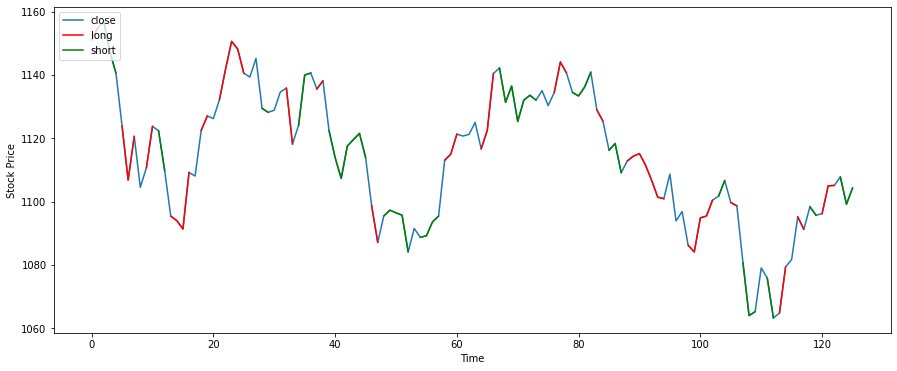

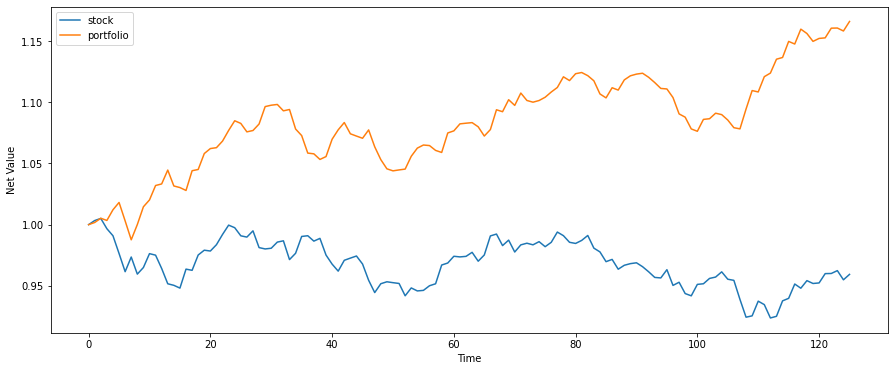

In [12]:
plot_start = 40  # the first few steps are ignored because history is not complete then
plot_end = len(portfolio_values)-1
x_data = range(plot_end - plot_start)
plt.figure(figsize=(15, 6))
plt.plot(x_data, closes[plot_start:plot_end])
plt.plot(x_data, longs[plot_start:plot_end], color='r')
plt.plot(x_data, shorts[plot_start:plot_end], color='g')
plt.legend(['close', 'long', 'short'], loc='upper left')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(x_data, closes[plot_start:plot_end]/closes[plot_start])
plt.plot(x_data, portfolio_values[plot_start:plot_end]/portfolio_values[plot_start])
plt.legend(['stock', 'portfolio'], loc='upper left')
plt.xlabel('Time')
plt.ylabel('Net Value')
plt.show()